In [1]:
import ROOT
from ROOT import RooRealVar, RooPolynomial, RooCategory, RooFit, \
                 RooDataSet, RooArgSet, RooCBShape, RooGaussian, \
                 RooExponential, RooAbsRealLValue, RooAddPdf, RooArgList 
import numpy as np
import uproot
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/05


In [2]:
from ROOT import RooChebychev

In [3]:
plt.style.use('style')

In [4]:
c = ROOT.TCanvas("c","Tau Mass Fit",660,660)
#c.Divide(1,2)
pad1 = ROOT.TPad("pad1", "Pad for histogram", 0,0.3,1,1.0)
pad2 = ROOT.TPad("pad2", "Pad for the ratio plot", 0,0.0,1,0.3)

In [41]:
filename_2018 = '../Ntuples/2018/T3MSelectionTreeInput_preapproval_v1_combined_2018UL_calo_check.root'

In [5]:
bujpsi_filename = '../Ntuples/2018/Muon_Validation/JPsiSelection_combined_mc_BuJPsi_private_trackerMuonId_v3.root'
bparking_filename = '../Ntuples/2018/Muon_Validation/JPsiSelection_combined_data_BScut_trackerMuonId_v3.root'

In [6]:
def t3mselection_reader(filename, br_list=['var_Muon1_Pt', 'var_Muon2_Pt', 'var_Muon3_Pt'], cuts=''):
    tree_list = ['TreeB', 'TreeS_Ds', 'TreeS_Bu', 'TreeS_Bd']
    tree_dict = {}
    for tree_ in tree_list:
        _ = root2array(filename, tree_, br_list, cuts)
        tree_dict[tree_] = rec2array(_)
    return tree_dict

In [7]:
def select_tracker_muons(df):
    return df[(df['Muon_IsGlobalMuon']==0) &
              (df['Muon_IsPFMuon']==1) &
              (df['Muon_IsTrackerMuon']==1)]

In [8]:
file_bujpsi = uproot.open(bujpsi_filename)
file_bparking = uproot.open(bparking_filename)

In [9]:
tree_bujpsi = file_bujpsi['tree']
tree_bparking = file_bparking['tree']

In [10]:
validation_data = tree_bparking.pandas.df(['Muon_seg_comp_dnn','Muon_IsTrackerMuon','Muon_IsGlobalMuon','Muon_IsPFMuon','InvMass', 'var_trackerMuonId_without_calo'])
validation_mc = tree_bujpsi.pandas.df(['Muon_seg_comp_dnn','Muon_IsTrackerMuon','Muon_IsGlobalMuon','Muon_IsPFMuon','InvMass','var_trackerMuonId_without_calo'])

In [31]:
# get the ideal binning
dnn_data = select_tracker_muons(validation_data)['Muon_seg_comp_dnn'].to_numpy()
dnn_mc = select_tracker_muons(validation_mc)['Muon_seg_comp_dnn'].to_numpy()
dnn_data = np.sort(dnn_data)
dnn_mc = np.sort(dnn_mc)
cuts_data = [dnn_data[int(len(dnn_data)*float(i)/8.0)] for i in xrange(8)]
cuts_mc = [dnn_mc[int(len(dnn_mc)*float(i)/8.0)] for i in xrange(8)]
print(cuts_data)
print(cuts_mc)

[0.0014715791, 0.17208287, 0.45493954, 0.663828, 0.7799622, 0.82385224, 0.8581305, 0.906946]
[0.0024623573, 0.46295148, 0.6852641, 0.7868614, 0.8242778, 0.85350215, 0.88510823, 0.92999697]


In [32]:
# get the ideal binning for tracker muon mva
tracker_data = select_tracker_muons(validation_data)['var_trackerMuonId_without_calo'].to_numpy()
tracker_mc = select_tracker_muons(validation_mc)['var_trackerMuonId_without_calo'].to_numpy()
tracker_data = np.sort(tracker_data)
tracker_mc = np.sort(tracker_mc)
cuts_data = [tracker_data[int(len(tracker_data)*float(i)/10.0)] for i in xrange(10)]
cuts_mc = [tracker_mc[int(len(tracker_mc)*float(i)/10.0)] for i in xrange(10)]
print(cuts_data)
print(cuts_mc)

[-0.36155713, -0.12034544, -0.086425394, -0.053279158, -0.025538532, 0.0030844288, 0.031011485, 0.059046518, 0.09341261, 0.12899753]
[-0.29916832, -0.09085624, -0.05415469, -0.025304133, 0.0049586855, 0.03433497, 0.060237348, 0.090768024, 0.11336745, 0.16712825]


In [13]:
trkmva_bins = [-0.36, -0.10, -0.08, -0.05, -0.02, 0.0, 0.03, 0.06, 0.09, 0.12, 0.36]

In [14]:
dnn_bins = [0.0, 0.15, 0.40, 0.65, 0.75, 0.80, 0.83, 0.85, 0.90, 0.95, 1.0]

In [15]:
jpsi_mass_categories_dnn = {'data': {}, 'mc': {}}
for ibin in xrange(len(dnn_bins)-1):
    jpsi_mass_categories_dnn['data']['dnn_bin_'+str(ibin+1)] = select_tracker_muons(validation_data[(validation_data['Muon_seg_comp_dnn']>dnn_bins[ibin])&
                                                                       (validation_data['Muon_seg_comp_dnn']<dnn_bins[ibin+1])])['InvMass'].to_numpy()
    jpsi_mass_categories_dnn['mc']['dnn_bin_'+str(ibin+1)] = select_tracker_muons(validation_mc[(validation_mc['Muon_seg_comp_dnn']>dnn_bins[ibin])&
                                                                       (validation_mc['Muon_seg_comp_dnn']<dnn_bins[ibin+1])])['InvMass'].to_numpy()

In [16]:
jpsi_mass_categories_tracker = {'data': {}, 'mc': {}}
for ibin in xrange(len(trkmva_bins)-1):
    jpsi_mass_categories_tracker['data']['trkmva_bin_'+str(ibin+1)] = select_tracker_muons(validation_data[(validation_data['var_trackerMuonId_without_calo']>trkmva_bins[ibin])&
                                                                       (validation_data['var_trackerMuonId_without_calo']<trkmva_bins[ibin+1])])['InvMass'].to_numpy()
    jpsi_mass_categories_tracker['mc']['trkmva_bin_'+str(ibin+1)] = select_tracker_muons(validation_mc[(validation_mc['var_trackerMuonId_without_calo']>trkmva_bins[ibin])&
                                                                       (validation_mc['var_trackerMuonId_without_calo']<trkmva_bins[ibin+1])])['InvMass'].to_numpy()

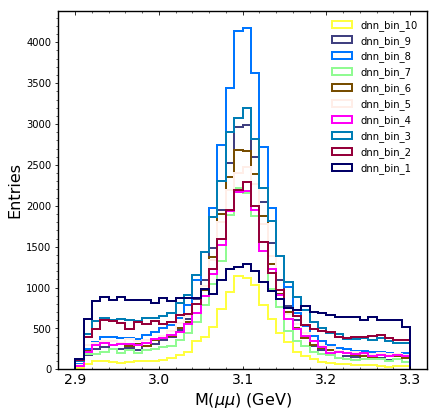

In [19]:
plt.figure(figsize=(6.6,6.6))
cols = [
    "#010067",
    "#95003A",
    "#007DB5",
    "#FF00F6",
    "#FFEEE8",
    "#774D00",
    "#90FB92",
    "#0076FF",
    "#404080",
    "#FFFF40"]
arr = []
leg = []
for i in xrange(len(dnn_bins)-1):
    leg.append('dnn_bin_'+str(i+1))
    arr.append(jpsi_mass_categories_dnn['data']['dnn_bin_'+str(i+1)])
plt.hist(arr, range=(2.9,3.3), bins=40, histtype='step', color=cols,
         linewidth=2, label=leg)
plt.xlabel('M($\mu\mu$) (GeV)')
plt.ylabel('Entries')
plt.legend(loc='upper right')
plt.show()

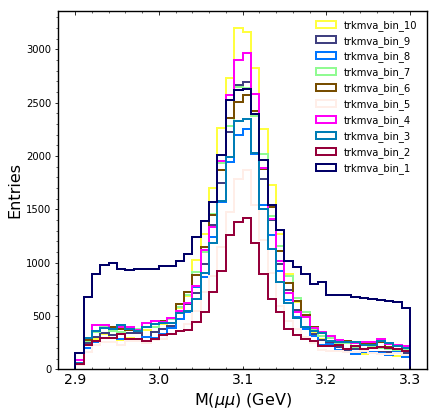

In [20]:
plt.figure(figsize=(6.6,6.6))
cols = [
    "#010067",
    "#95003A",
    "#007DB5",
    "#FF00F6",
    "#FFEEE8",
    "#774D00",
    "#90FB92",
    "#0076FF",
    "#404080",
    "#FFFF40"]
arr = []
leg = []
for i in xrange(len(trkmva_bins)-1):
    leg.append('trkmva_bin_'+str(i+1))
    arr.append(jpsi_mass_categories_tracker['data']['trkmva_bin_'+str(i+1)])
plt.hist(arr, range=(2.9,3.3), bins=40, histtype='step', color=cols,
         linewidth=2, label=leg)
plt.xlabel('M($\mu\mu$) (GeV)')
plt.ylabel('Entries')
plt.legend(loc='upper right')
plt.show()

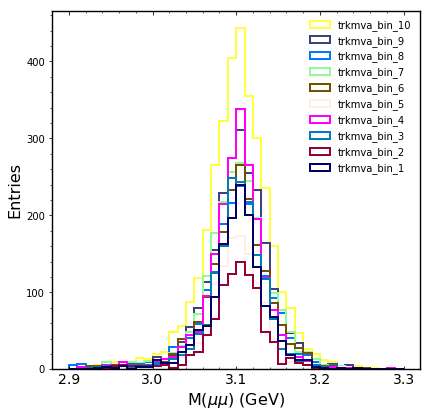

In [23]:
plt.figure(figsize=(6.6,6.6))
cols = [
    "#010067",
    "#95003A",
    "#007DB5",
    "#FF00F6",
    "#FFEEE8",
    "#774D00",
    "#90FB92",
    "#0076FF",
    "#404080",
    "#FFFF40"]
arr = []
leg = []
for i in xrange(len(trkmva_bins)-1):
    leg.append('trkmva_bin_'+str(i+1))
    arr.append(jpsi_mass_categories_tracker['mc']['trkmva_bin_'+str(i+1)])
plt.hist(arr, range=(2.9,3.3), bins=40, histtype='step', color=cols,
         linewidth=2, label=leg)
plt.xlabel('M($\mu\mu$) (GeV)')
plt.ylabel('Entries')
plt.legend(loc='upper right')
plt.show()

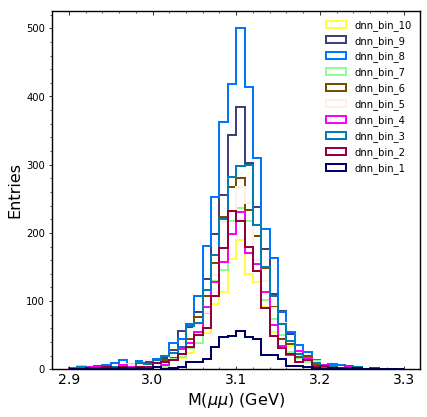

In [34]:
plt.figure(figsize=(6.6,6.6))
cols = [
    "#010067",
    "#95003A",
    "#007DB5",
    "#FF00F6",
    "#FFEEE8",
    "#774D00",
    "#90FB92",
    "#0076FF",
    "#404080",
    "#FFFF40"]
arr = []
leg = []
for i in xrange(len(trkmva_bins)-1):
    leg.append('dnn_bin_'+str(i+1))
    arr.append(jpsi_mass_categories_dnn['mc']['dnn_bin_'+str(i+1)])
plt.hist(arr, range=(2.9,3.3), bins=40, histtype='step', color=cols,
         linewidth=2, label=leg)
plt.xlabel('M($\mu\mu$) (GeV)')
plt.ylabel('Entries')
plt.legend(loc='upper right')
plt.show()

In [26]:
# mva correction weights
dnn_correction_weights = [1.237887236,
0.9955392782,
1.026282153,
1.104368833,
1.078790216,
1.049521213,
1.004121382,
0.9835349021,
0.9301057933,
0.7328824041]

trkmva_correction_weights = [
    1.18,
1.07,
1.08,
1.08,
1.17,
0.95,
1.04,
1.01,
0.92,
0.80
]

In [28]:
dnn_data_jpsi_weights = np.ones(len(dnn_data))
dnn_jpsi_mc_weights = []
for d in dnn_mc:
    for i in xrange(len(trkmva_bins)-1):
        if d > trkmva_bins[i] and d <= trkmva_bins[i+1]: dnn_jpsi_mc_weights.append(dnn_correction_weights[i])

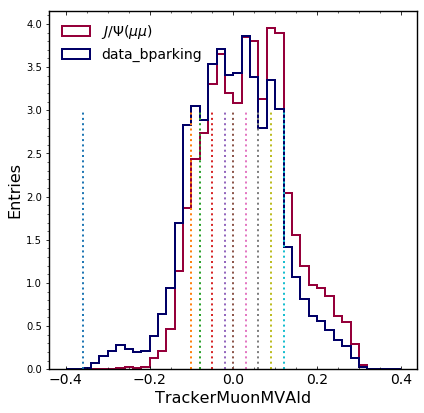

In [29]:
plt.figure(figsize=(6.6,6.6))
cols = [
    "#010067",
    "#95003A"]
arr = []
leg = []
plt.hist([dnn_data, dnn_mc], range=(-0.4,0.4), bins=40, histtype='step', color=cols,
          linewidth=2, label=['data_bparking', '$J/\Psi(\mu\mu)$'], density=True)
#          weights = [dnn_data_jpsi_weights, dnn_jpsi_mc_weights])
plt.xlabel('TrackerMuonMVAId')
plt.ylabel('Entries')
plt.legend(loc='upper left', fontsize=14)
for i in xrange(len(trkmva_bins)-1): plt.plot([trkmva_bins[i],trkmva_bins[i]],[0,3.0], linestyle='dotted', linewidth=2)
plt.show()

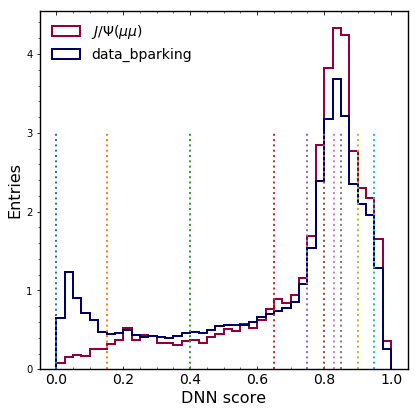

In [36]:
plt.figure(figsize=(6.6,6.6))
cols = [
    "#010067",
    "#95003A"]
arr = []
leg = []
plt.hist([dnn_data, dnn_mc], range=(0,1.0), bins=40, histtype='step', color=cols,
          linewidth=2, label=['data_bparking', '$J/\Psi(\mu\mu)$'], density=True,
          weights = [dnn_data_jpsi_weights, dnn_jpsi_mc_weights])
plt.xlabel('DNN score')
plt.ylabel('Entries')
plt.legend(loc='upper left', fontsize=14)
for i in xrange(len(dnn_bins)-1): plt.plot([dnn_bins[i],dnn_bins[i]],[0,3.0], linestyle='dotted', linewidth=2)
plt.show()

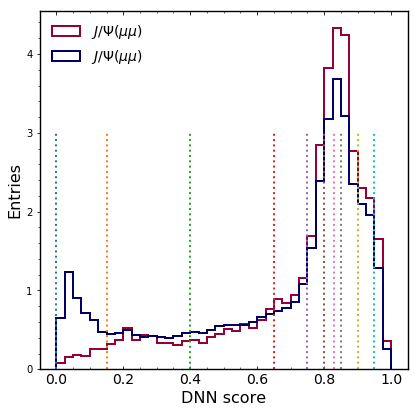

In [37]:
plt.figure(figsize=(6.6,6.6))
cols = [
    "#010067",
    "#95003A"]
arr = []
leg = []
plt.hist([dnn_data, dnn_mc], range=(0,1.0), bins=40, histtype='step', color=cols,
          linewidth=2, label=['$J/\Psi(\mu\mu)$', '$J/\Psi(\mu\mu)$'], density=True,
          weights = [dnn_data_jpsi_weights, dnn_jpsi_mc_weights])
plt.xlabel('DNN score')
plt.ylabel('Entries')
plt.legend(loc='upper left', fontsize=14)
for i in xrange(len(dnn_bins)-1): plt.plot([dnn_bins[i],dnn_bins[i]],[0,3.0], linestyle='dotted', linewidth=2)
plt.show()

In [42]:
file_2018 = uproot.open(filename_2018)
tree_ds_2018 = file_2018['TreeS_Ds']
tree_bkg_2018 = file_2018['TreeB']

In [ ]:
tree_ds_2018.keys()

In [43]:
ds_df = tree_ds_2018.pandas.df(['muon3_seg_comp_dnn','threeGlobal','var_Muon3_Eta','var_trackerMuonId_without_calo'])
data_df = tree_bkg_2018.pandas.df(['muon3_seg_comp_dnn','threeGlobal','var_Muon3_Eta','var_trackerMuonId_without_calo'])

In [44]:
ds_dnn_scores_tracker_barrel = ds_dnn_scores[(ds_dnn_scores['threeGlobal']==0) & (abs(ds_dnn_scores['var_Muon3_Eta'])<0.9)]['muon3_seg_comp_dnn'].to_numpy()
data_dnn_scores_tracker_barrel = data_dnn_scores[(data_dnn_scores['threeGlobal']==0) & (abs(ds_dnn_scores['var_Muon3_Eta'])<0.9)]['muon3_seg_comp_dnn'].to_numpy()
ds_dnn_scores_tracker_endcap = ds_dnn_scores[(ds_dnn_scores['threeGlobal']==0) & (abs(ds_dnn_scores['var_Muon3_Eta'])>=0.9)]['muon3_seg_comp_dnn'].to_numpy()
data_dnn_scores_tracker_endcap = data_dnn_scores[(data_dnn_scores['threeGlobal']==0) & (abs(ds_dnn_scores['var_Muon3_Eta'])>=0.9)]['muon3_seg_comp_dnn'].to_numpy()

NameError: name 'ds_dnn_scores' is not defined

In [ ]:
ds_trkmva_scores_tracker = ds_df[(ds_df['threeGlobal']==0)]['var_trackerMuonId_without_calo'].to_numpy()
data_trkmva_scores_tracker = data_df[(data_df['threeGlobal']==0)]['var_trackerMuonId_without_calo'].to_numpy()
ds_trkmva_scores_tracker_barrel = ds_df[(ds_df['threeGlobal']==0) & (abs(ds_df['var_Muon3_Eta'])<0.9)]['var_trackerMuonId_without_calo'].to_numpy()
data_trkmva_scores_tracker_barrel = data_df[(data_df['threeGlobal']==0) & (abs(ds_df['var_Muon3_Eta'])<0.9)]['var_trackerMuonId_without_calo'].to_numpy()
ds_trkmva_scores_tracker_endcap = ds_df[(ds_df['threeGlobal']==0) & (abs(ds_df['var_Muon3_Eta'])>=0.9)]['var_trackerMuonId_without_calo'].to_numpy()
data_trkmva_scores_tracker_endcap = data_df[(data_df['threeGlobal']==0) & (abs(ds_df['var_Muon3_Eta'])>=0.9)]['var_trackerMuonId_without_calo'].to_numpy()

In [ ]:
ds_unity_weights = np.ones(len(ds_trkmva_scores_tracker))
ds_unity_weights_barrel = np.ones(len(ds_trkmva_scores_tracker_barrel))
ds_unity_weights_endcap = np.ones(len(ds_trkmva_scores_tracker_endcap))

In [ ]:
ds_dnn_scores_tracker = ds_dnn_scores[ds_dnn_scores['threeGlobal']==0]['muon3_seg_comp_dnn'].to_numpy()
data_dnn_scores_tracker = data_dnn_scores[data_dnn_scores['threeGlobal']==0]['muon3_seg_comp_dnn'].to_numpy()

In [ ]:
ds_dnn_scores_tracker_corr = []
ds_dnn_scores_tracker_corr_barrel = []
ds_dnn_scores_tracker_corr_endcap = []
for d in ds_dnn_scores_tracker:
    for i in xrange(len(dnn_bins)-1):
        if d > dnn_bins[i] and d <= dnn_bins[i+1]: ds_dnn_scores_tracker_corr.append(dnn_correction_weights[i])

for d in ds_dnn_scores_tracker_barrel:
    for i in xrange(len(dnn_bins)-1):
        if d > dnn_bins[i] and d <= dnn_bins[i+1]: ds_dnn_scores_tracker_corr_barrel.append(dnn_correction_weights[i])

for d in ds_dnn_scores_tracker_endcap:
    for i in xrange(len(dnn_bins)-1):
        if d > dnn_bins[i] and d <= dnn_bins[i+1]: ds_dnn_scores_tracker_corr_endcap.append(dnn_correction_weights[i])

In [ ]:
ds_trkmva_scores_tracker_corr = []
ds_trkmva_scores_tracker_corr_barrel = []
ds_trkmva_scores_tracker_corr_endcap = []
for d in ds_trkmva_scores_tracker:
    for i in xrange(len(trkmva_bins)-1):
        if d > trkmva_bins[i] and d <= trkmva_bins[i+1]: ds_trkmva_scores_tracker_corr.append(trkmva_correction_weights[i])

for d in ds_trkmva_scores_tracker_barrel:
    for i in xrange(len(trkmva_bins)-1):
        if d > trkmva_bins[i] and d <= trkmva_bins[i+1]: ds_trkmva_scores_tracker_corr_barrel.append(trkmva_correction_weights[i])

for d in ds_trkmva_scores_tracker_endcap:
    for i in xrange(len(trkmva_bins)-1):
        if d > trkmva_bins[i] and d <= trkmva_bins[i+1]: ds_trkmva_scores_tracker_corr_endcap.append(trkmva_correction_weights[i])

In [ ]:
bkg_dnn_scores_tracker_corr=np.ones((len(data_dnn_scores_tracker),1))

In [ ]:
plt.figure(figsize=(6.6,6.6))
plt.hist([data_dnn_scores_tracker, ds_dnn_scores_tracker],
        label=['data','DsToTau'], bins=40,
        color=['tab:blue','tab:red'],
        density=True, linewidth=2, histtype='step', weights=[bkg_dnn_scores_tracker_corr, ds_dnn_scores_tracker_corr])
plt.xlabel('DNN score')
plt.legend(loc='upper left', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(6.6,6.6))
plt.hist([data_dnn_scores_tracker, ds_dnn_scores_tracker],
        label=['data','DsToTau'], bins=40,
        color=['tab:blue','tab:red'],
        density=True, linewidth=2, histtype='step')
plt.xlabel('DNN score')
plt.legend(loc='upper left', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(6.6,6.6))
plt.hist([ds_trkmva_scores_tracker, ds_trkmva_scores_tracker],
        label=['DsToTau','DsToTau (corr)'], bins=40,
        color=['tab:orange','tab:red'],
        density=True, linewidth=2, histtype='step', weights=[ds_unity_weights, ds_trkmva_scores_tracker_corr])
plt.xlabel('DNN score')
plt.legend(loc='upper left', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(6.6,6.6))
plt.hist([ds_trkmva_scores_tracker, ds_trkmva_scores_tracker],
        label=['DsToTau','DsToTau (corr)'], bins=40,
        color=['tab:orange','tab:red'],
        density=True, linewidth=2, histtype='step', weights=[ds_unity_weights, ds_trkmva_scores_tracker_corr])
plt.xlabel('DNN score')
plt.legend(loc='upper left', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(6.6,6.6))
plt.hist([ds_dnn_scores_tracker_endcap, ds_dnn_scores_tracker_endcap],
        label=['DsToTau','DsToTau (corr)'], bins=40,
        color=['tab:orange','tab:red'],
        density=True, linewidth=2, histtype='step', weights=[ds_unity_weights_endcap, ds_dnn_scores_tracker_corr_endcap])
plt.xlabel('DNN score')
plt.legend(loc='upper left', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(6.6,6.6))
plt.hist([ds_dnn_scores_tracker_barrel, ds_dnn_scores_tracker_barrel],
        label=['DsToTau','DsToTau (corr)'], bins=40,
        color=['tab:orange','tab:red'],
        density=True, linewidth=2, histtype='step', weights=[ds_unity_weights_barrel, ds_dnn_scores_tracker_corr_barrel])
plt.xlabel('DNN score')
plt.legend(loc='upper left', fontsize=14)
plt.show()